# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [ ]:
!pip install kaggle kagglehub

# Upload file kaggle.json
from google.colab import files
print("Silakan upload file kaggle.json Anda:")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nOtentikasi Kaggle berhasil.")

    import kagglehub
    import os
    print("Mulai mengunduh dataset...")
    path_unduhan_utama = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
    print(f"Dataset diunduh ke: {path_unduhan_utama}")

    dataset_path_final = os.path.join(path_unduhan_utama, 'garbage-dataset')
    print(f"Path yang akan digunakan model: {dataset_path_final}")
else:
    print("\nUpload dibatalkan atau file yang diupload bukan kaggle.json.")

Silakan upload file kaggle.json Anda:


Saving kaggle.json to kaggle.json

Otentikasi Kaggle berhasil.
Mulai mengunduh dataset...
Dataset diunduh ke: /kaggle/input/garbage-classification-v2
Path yang akan digunakan model: /kaggle/input/garbage-classification-v2/garbage-dataset


In [ ]:
# display information about available GPU devices
!nvidia-smi

Sat Jan 20 01:18:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries

In [3]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.6 MB/s eta 0:00:00


In [4]:
!pip install split-folders
!pip install optuna
!pip install --upgrade nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=020b492d1365f37cbe2d30a6772c2889a365fd7bbe948b4daf0f19366a029074
  Stored in directory: /root/.cache/pip/wheels/47/50/9e/29dc79037d74c3c1bb4a8661fb608e8674b7e4260d6a3f8f51
Successfully built nvidia-ml-py3


In [5]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

/tmp/ipython-input-5-4272007560.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [7]:
data_dir = dataset_path_final

Cleaning the working directory if there are any files in it

In [ ]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'

os.makedirs(folder_path, exist_ok=True)

print(f"Menghapus isi dari direktori: {folder_path}")
remove_folder_contents(folder_path)
print("Pembersihan selesai.")

Menghapus isi dari direktori: /kaggle/working
Pembersihan selesai.


Copying the dataset to the working directory to allow data cleaning

In [10]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

'/kaggle/working/dataset'

In [11]:
data_dir  = '/kaggle/working/dataset'

In [12]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [13]:
count=0
image_extensions = [".png", ".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/plastic/plastic_2038.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2038.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_603.jpg is not an image
/kaggle/working/dataset/plastic/plastic_603.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_613.jpg is not an image
/kaggle/working/dataset/plastic/plastic_613.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_160.jpg is not an image
/kaggle/working/dataset/plastic/plastic_160.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2184.jpg is not an image
/kaggle/working/dataset/paper/paper_2184.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2784.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1678.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1433.jpg is not an image
/kaggle/working/dataset/pap

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [14]:
os.mkdir('data')

In [15]:
os.chdir('data')

In [16]:
os.getcwd()

'/content/data'

In [17]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [18]:
os.chdir('/kaggle/working/')

In [19]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [20]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [21]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 19750 files [00:07, 2535.45 files/s]


In [22]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [23]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [24]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

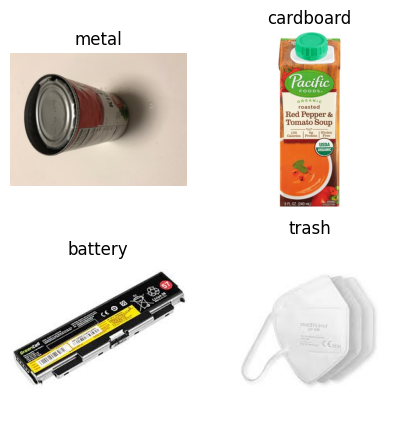

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) 
axes = axes.ravel()

for i in np.arange(0, 4):

    category = random.choice(os.listdir(train_path))
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) 

    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category)
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [26]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))
print(f"\nTotal number of train images: {total}")

Shoes: 1581
Glass: 2448
Trash: 757
Metal: 816
Battery: 755
Biological: 797
Plastic: 1584
Paper: 1339
Cardboard: 1458
Clothes: 4261

Total number of train images: 15796


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [27]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [28]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[755, 797, 1458, 4261, 2448, 816, 1339, 1584, 1581, 757]

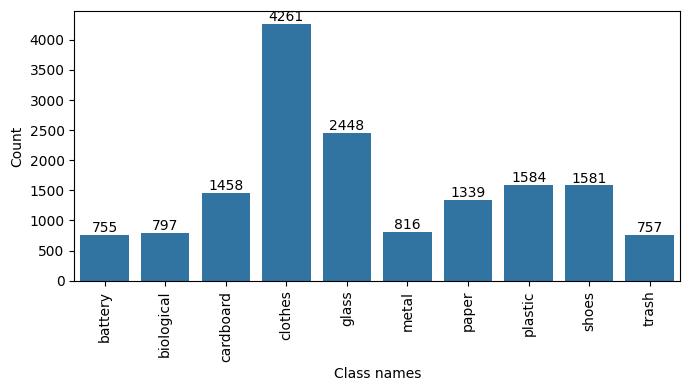

In [29]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [30]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category))
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1

    print(f'Deleted {delete} in {category}')


Deleted 581 in shoes
Deleted 1448 in glass
Deleted 0 in trash
Deleted 0 in metal
Deleted 0 in battery
Deleted 0 in biological
Deleted 584 in plastic
Deleted 339 in paper
Deleted 458 in cardboard
Deleted 3261 in clothes


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [31]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

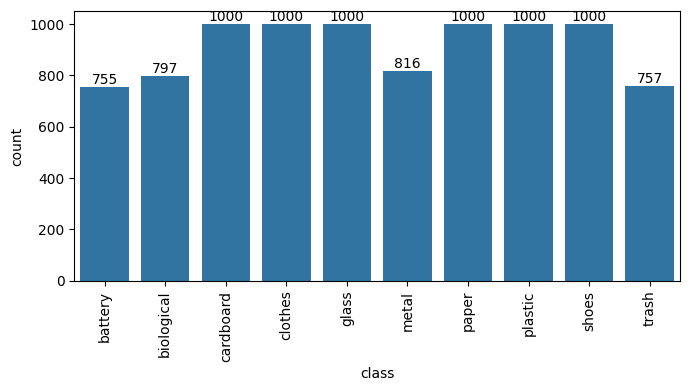

In [32]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [33]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [34]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 415.7873
Mean Height: 406.8064


Let's set the size of the input data (image size) taking into account the found average values

In [35]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [36]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [37]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [38]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9125 files belonging to 10 classes.


In [39]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1983 files belonging to 10 classes.


In [40]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1971 files belonging to 10 classes.


Create directories for train and test logs and write logs to it

In [41]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2S model, which has 88 layers, was selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


Loading the model

In [42]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [43]:
base_model.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 400, 400,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 200, 200,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 200, 200,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 200, 200,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 200, 200,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 200, 200,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 200, 200,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 200, 200,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 200, 200,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 100, 100,  │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 100, 100,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 100, 100,  │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [44]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [45]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2),
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

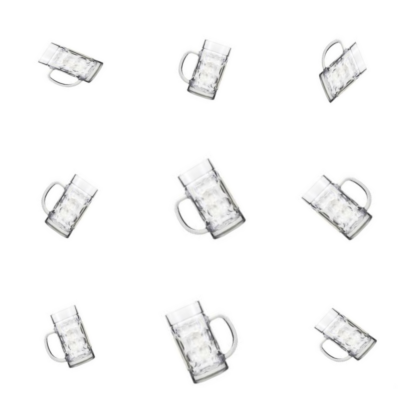

In [46]:
for image, _ in train_data.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [47]:
name="EfficientNetV2S"

EfficientNetV2S_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [48]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [49]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, None, None,     │    20,331,360 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,496,618 (78.19 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [ ]:
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)

    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)

    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):

    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [51]:
EfficientNetV2S_callback = create_callback(name)

Let's set the number of training epochs

In [52]:
EPOCH=20

Let's train the model

In [53]:
import time
start_time = time.time()
EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data,
                                                    epochs=EPOCH,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data,
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7751 - loss: 0.7402

286/286 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.7753 - loss: 0.7393 - val_accuracy: 0.9340 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9080 - loss: 0.2740

286/286 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9080 - loss: 0.2740 - val_accuracy: 0.9432 - val_loss: 0.1925 - learning_rate: 0.0010
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9160 - loss: 0.2420 - val_accuracy: 0.9432 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.9199 - loss: 0.2379

286/286 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9200 - loss: 0.2379 - val_accuracy: 0.9437 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.9355 - loss: 0.1916

286/286 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - accuracy: 0.9355 - loss: 0.1916 - val_accuracy: 0.9482 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.9391 - loss: 0.1773

286/286 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9391 - loss: 0.1773 - val_accuracy: 0.9533 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.9459 - loss: 0.1594 - val_accuracy: 0.9513 - val_loss: 0.1564 - learning_rate: 0.0010
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 302s 993ms/step - accuracy: 0.9523 - loss: 0.1477 - val_accuracy: 0.9503 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 9/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9485 - loss: 0.1605
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
286/286 ━━━━━━━━━━━━━━━━━━━━ 302s 921ms/step - accuracy: 0.9485 - loss: 0.1604 - val_accuracy: 0.9523 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 10/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 255s 890ms/step - accuracy: 0.9595 - loss: 0.1256 - val_accuracy: 0.9498 - val_loss: 0.1576 - learning_rate: 2.0000e-04
Epoch 10: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [54]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Close the SummaryWriter

In [55]:
writer.close()
train_writer.close()
test_writer.close()

In [56]:
EfficientNetV2S_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [58]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

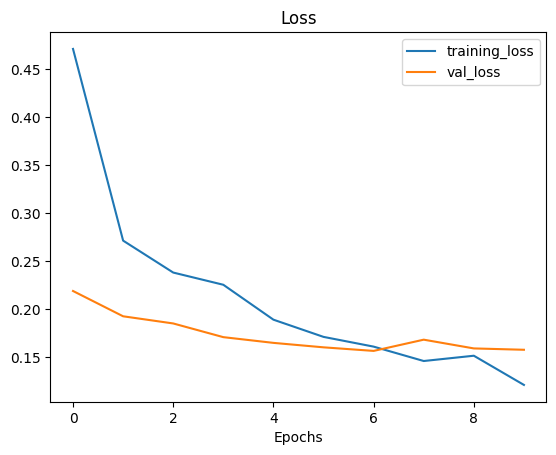

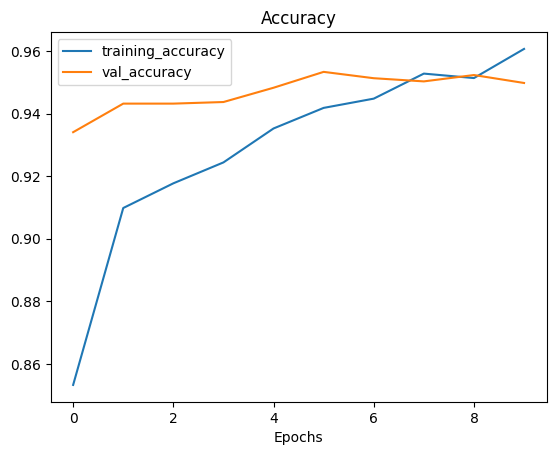

In [59]:
plot_loss_curves(EfficientNetV2S_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [60]:
test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

In [61]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.14889
Test Accuracy: 95.71%


Given the limited data set, we obtained a good accuracy of 95%.

Let's look at the main classification metrics

In [62]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 525ms/step


In [63]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [65]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.99      0.95      0.97        95
  biological       0.97      0.95      0.96       101
   cardboard       0.94      0.96      0.95       183
     clothes       1.00      0.99      0.99       534
       glass       0.97      0.93      0.95       307
       metal       0.85      0.98      0.91       102
       paper       0.94      0.93      0.93       168
     plastic       0.91      0.92      0.92       198
       shoes       0.98      0.99      0.98       199
       trash       0.90      0.89      0.89        96

    accuracy                           0.96      1983
   macro avg       0.94      0.95      0.95      1983
weighted avg       0.96      0.96      0.96      1983



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [66]:
import itertools

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

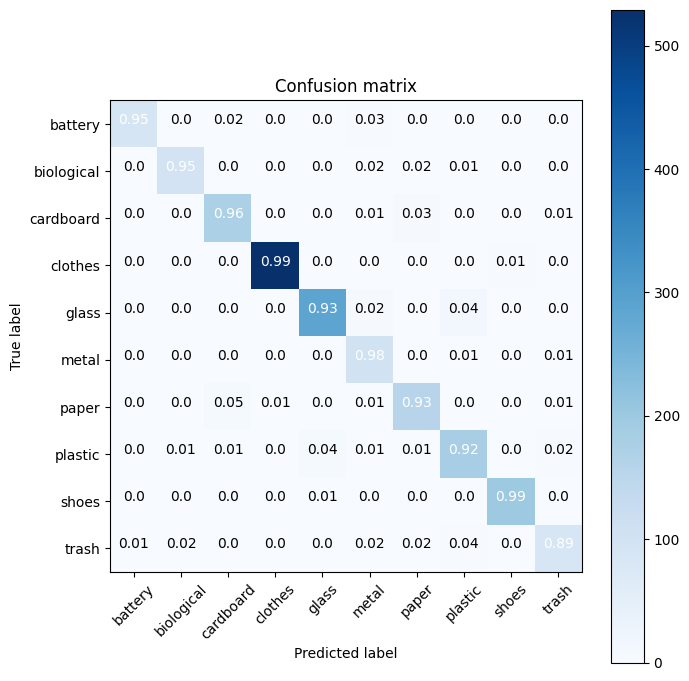

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

In [70]:
EfficientNetV2S_model.save('EfficientNetV2S_model.keras')